In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

We have a hidden process 

$$ X_t = \mu_0 + \phi x_{t-1} + w_t $$ 
and an observation $$ y_t = x_t + v_t $$
where we assume $w_t = w$ ~ $\cal{N}$ $(0,Q^2)$ and $v_t = v$ ~ $\cal{N}$ $(0,R^2)$.

We plot a graph below to see the first 10 positions.

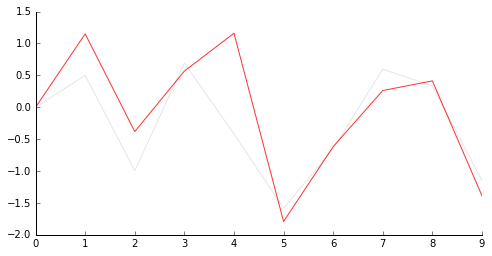

In [110]:

from numpy import dot, sum, tile, linalg
from numpy.linalg import inv, pinv
# from numpy.linalg import det
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op



np.random.seed(4) # make it reproducible
nsim = 100


X = [0.0]
Y = [0.0]
mu_0 = 0.0
phi = 1.0
Q = 1.0
R =  1.0
w = np.random.normal(0, Q, nsim) #system noise error
v = np.random.normal(0, R, nsim) #observation errors

for i in xrange(1,nsim):
    x = X[0] + X[0]*phi + w[i]
    y = x + v[i]
    X.append(x)
    Y.append(y)


X = np.array(X)
Y = np.array(Y)
plt.figure(figsize=(8, 4))
plt.plot(xrange(0,10),X[:10], alpha=.2, color='grey')
plt.plot(xrange(0,10),Y[:10], alpha=0.8, color='r')

remove_border()
# pinv(outer(X, Y, out=None))


At a given moment $t$ before we observe $y_t$ we have the following: the observations $y_{1:t-1}$ and our estimates  $\theta_{t-1} = \{\sigma_{t-1},\tau_{t-1}\}$.  
We want to calculate $$\cal{L}(\theta|y_{1:t}) = \prod_{i=1}^t p(y_i | y_{1:i-1} , \theta_{t-1})$$

To get $p(y_i | y_{1:i-1} , \theta_{t-1})$ we calculate:    

  $p(x_t | y_{1:t-1}) = \cal{N}(\mu_{t|t-1};\Sigma_{t|t-1})=\cal{N}(\mu_{t-1} ; \Sigma_{t-1} + \sigma_{t-1}^2) $


We __then__ observe $y_t$ and get to calculate:    

  $p(x_t | y_{1:t}) = \cal{N}(\mu_{t};\Sigma_{t} )$ $= \cal{N}$ $(\mu_{t|t-1}+ K_t (y_t - \mu_{t-1} ); (I-K_t) \Sigma_{t|t-1} )$ where $K_t =\Sigma_{t|t-1} (\Sigma_{t|t-1} + \tau^2) ^{-1} $

to finally get:   

$p(y_t | y_{1:t-1}) = \cal{N}(y|\mu_{t|t-1};\Sigma_{t|t-1} + \tau_{t-1}^2)$   
 
If we plug everything into the log likelihood we get :   

$$ \log \cal{L}(\theta_t|y_{1:t}) = \sum_{i=1}^t \log p(y_i | y_{1:i-1} )
$$
We find the value $\theta^* =$argmax $\log \cal{L}(\theta_t|y_{1:t})$ and set $\theta_t = \theta^*$.
For the next moment $t \to t-1$ and we repeat all the steps.
 

In [111]:
def normpdf(x, mean, sd):
    var = float(sd)**2
    pi = 3.1415926
    denom = (2*pi*var)**.5
    num = np.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom


def loglikelihood(theta, y, mu, sigma):
    Q,R = theta
    likl = 0.0   
    for i in range(len(y)):
        likl = likl + np.log(normpdf(y[i], mu[i], sigma[i]+R**2))
    return likl


In [112]:
mus = [2]
sigmas = [2]
nll = lambda *args: -loglikelihood(*args)


for i in xrange(1,nsim):
##  prediction step for the next moment - where I thought it would go next
    mu_t_t_1 = mus[i-1]
    sigma_t_t_1 = sigmas[i-1] + Q**2

##  measurement step - where I thought it actually was after I got the observation
    K_t = sigma_t_t_1 /(sigma_t_t_1 + R**2)
    mu_t = mu_t_t_1 + K_t * (Y[i] -  mu_t_t_1 )
    sigma_t = (1.0-K_t)*sigma_t_t_1     
    mus.append(mu_t)
    sigmas.append(sigma_t)
    
    result = op.minimize(nll, x0 = [4,4], args=(Y[:i], mus, sigmas) ,method= 'nelder-mead')
    Q, R = result["x"]

Below we plot our best estimate of the hidden state

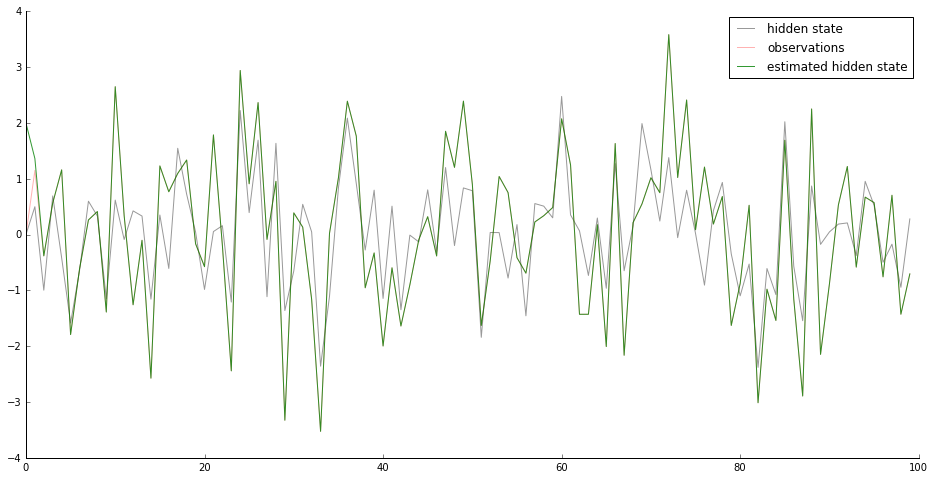

In [120]:
plt.figure(figsize=(16, 8))
plt.plot(xrange(0,nsim),X, alpha=.4, color='k', lw=1, label = "hidden state")
plt.plot(xrange(0,nsim),Y, alpha=0.3, color='r', lw=1, label = "observations")
#plt.plot(xrange(0,nsim),preds, alpha=0.8, color='b')
# plt.plot(xrange(0,nsim),msrs - np.sqrt(tau_sq), alpha=0.8, color='y')
# plt.plot(xrange(0,nsim),msrs + np.sqrt(tau_sq), alpha=0.8, color='y')
plt.plot(xrange(0,nsim),mus, lw = 1, alpha=0.8, color='g', label = "estimated hidden state")

plt.legend()
remove_border()
# pinv(outer(X, Y, out=None))

can formulate a prediction about the next, still unobserved, moment $t$ according to our assumed model. The position of the state $X_t$ given the observation in hand $1:t-1$ is expressed as a distribution $p(X_t | Y_{1:t-1})$. Because the noise is assumed Gaussian, the distribution for the predicted state is also Gaussian. Note that because of the Markovian property, the prediction based on $Y_{1:t-1}$ is the same as the one based just on $Y_{t-1}$. Specifically we have that 
$$ p(X_t | Y_{1:t-1}) = N(\mu_{t|t-1}, \Sigma_{t|t-1}) $$ 
$$\mu_{t|t-1} = \mu_0 + \phi \mu_{t-1} $$
$$ \Sigma_{t|t-1} = \Sigma_{t-1} + \sigma_t^2 $$  

Note that the above formulas does not directly include any observation values. That's because the information is already encoded in the $\mu_{t-1},\Sigma_{t-1}$ values.  


Once the observation $Y_t$ for time $t$ has been made we need to update our values. We calculate the updated $\mu_t, \Sigma_t$ as follows:
$$ p(X_t | Y_{1:t}) = N(X_t|\mu_t, \Sigma_{t}) $$ 

$$ \mu_t = \mu_{t|t-1} + K_t r_t $$
$$ \Sigma_t = (I-K_t C_t)\Sigma_{t|t-1}$$
where 
$$ r_t = y_t - \hat{y}_t,  \hat{y}_t = E[Y_t|Y_{1:t-1}] = \mu_{t|t-1}$$ 
and $K_t$ is the Kalman gain matrix, given by 
$$ K_t = \Sigma_{t|t-1} S_t^{-1}, S_t = \Sigma_{t|t-1} + \tau^2 $$